# Autoencoders and GANs

# Setup

In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from sklearn.manifold import TSNE

In [3]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("ggplot")
warnings.filterwarnings(action="ignore")
os.chdir('output')

A couple utility functions to plot grayscale 28x28 image:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [5]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [6]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=5)

Epoch 1/5
2/2 [==============================] - 0s 867us/step - loss: 0.9077
Epoch 2/5
2/2 [==============================] - 0s 972us/step - loss: 0.2792
Epoch 3/5
2/2 [==============================] - 0s 862us/step - loss: 0.0960
Epoch 4/5
2/2 [==============================] - 0s 787us/step - loss: 0.0874
Epoch 5/5
2/2 [==============================] - 0s 836us/step - loss: 0.0767


In [8]:
codings = encoder.predict(X_train)

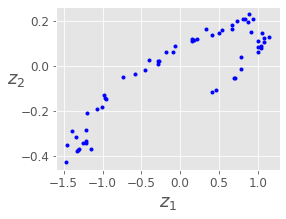

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [13]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [14]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=5,
                         validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3357 - rounded_accuracy: 0.8892 - val_loss: 0.3143 - val_rounded_accuracy: 0.9053
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3056 - rounded_accuracy: 0.9153 - val_loss: 0.3082 - val_rounded_accuracy: 0.9076
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2994 - rounded_accuracy: 0.9206 - val_loss: 0.2979 - val_rounded_accuracy: 0.9241
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2956 - rounded_accuracy: 0.9240 - val_loss: 0.2948 - val_rounded_accuracy: 0.9266
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2926 - rounded_accuracy: 0.9268 - val_loss: 0.2928 - val_rounded_accuracy: 0.9292


This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [15]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

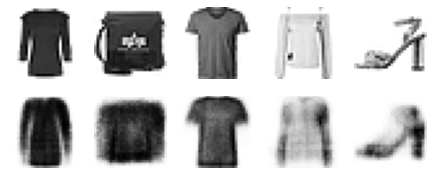

In [16]:
show_reconstructions(stacked_ae)

# Visualizing Fashion MNIST

In [17]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

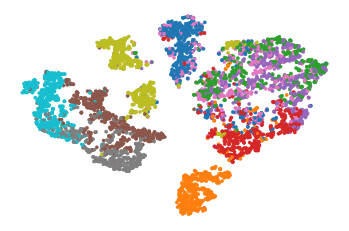

In [18]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

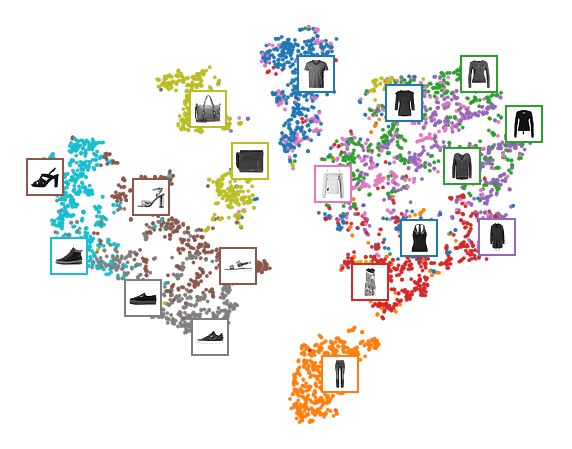

In [20]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [21]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [22]:
keras.backend.clear_session()

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3255 - rounded_accuracy: 0.8970 - val_loss: 0.3036 - val_rounded_accuracy: 0.9209
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2968 - rounded_accuracy: 0.9228 - val_loss: 0.2954 - val_rounded_accuracy: 0.9276
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2908 - rounded_accuracy: 0.9284 - val_loss: 0.2913 - val_rounded_accuracy: 0.9312
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2879 - rounded_accuracy: 0.9312 - val_loss: 0.2906 - val_rounded_accuracy: 0.9251
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2860 - rounded_accuracy: 0.9329 - val_loss: 0.2862 - val_rounded_accuracy: 0.9339


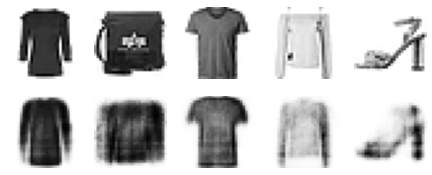

In [23]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [24]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=5, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [25]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Epoch 1/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3449 - rounded_accuracy: 0.8869 - val_loss: 0.3119 - val_rounded_accuracy: 0.9153
Epoch 2/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3035 - rounded_accuracy: 0.9206 - val_loss: 0.3002 - val_rounded_accuracy: 0.9250
Epoch 3/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2948 - rounded_accuracy: 0.9285 - val_loss: 0.2935 - val_rounded_accuracy: 0.9310
Epoch 4/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2892 - rounded_accuracy: 0.9339 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/5
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2855 - rounded_accuracy: 0.9375 - val_loss: 0.2859 - val_rounded_accuracy: 0.9381
Epoch 1/5
1719/1719 [==============================] - 1s 692us/step - loss: 0.3782 - val_loss: 0.1513
Epoch 2/5
1719/1719 [==============================] - 1s 655us/step - loss: 0.1232 - val_loss: 0.1072

In [26]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

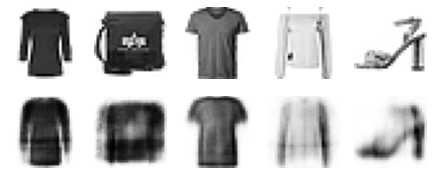

In [27]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [28]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2881 - rounded_accuracy: 0.9339 - val_loss: 0.2897 - val_rounded_accuracy: 0.9340
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2877 - rounded_accuracy: 0.9342 - val_loss: 0.2894 - val_rounded_accuracy: 0.9340
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2874 - rounded_accuracy: 0.9344 - val_loss: 0.2892 - val_rounded_accuracy: 0.9341
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2872 - rounded_accuracy: 0.9346 - val_loss: 0.2890 - val_rounded_accuracy: 0.9342
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2870 - rounded_accuracy: 0.9347 - val_loss: 0.2888 - val_rounded_accuracy: 0.9343


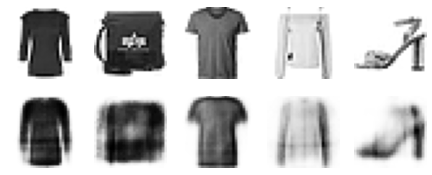

In [29]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [30]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3001 - rounded_accuracy: 0.9199 - val_loss: 0.2797 - val_rounded_accuracy: 0.9411
Epoch 2/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2754 - rounded_accuracy: 0.9415 - val_loss: 0.2730 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 25s 15ms/step - loss: 0.2710 - rounded_accuracy: 0.9459 - val_loss: 0.2704 - val_rounded_accuracy: 0.9492
Epoch 4/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2685 - rounded_accuracy: 0.9484 - val_loss: 0.2688 - val_rounded_accuracy: 0.9495
Epoch 5/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.2668 - rounded_accuracy: 0.9501 - val_loss: 0.2667 - val_rounded_accuracy: 0.9519


In [31]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

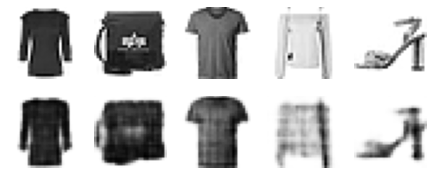

In [32]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [33]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [34]:
history = recurrent_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.5073 - rounded_accuracy: 0.7561 - val_loss: 0.4363 - val_rounded_accuracy: 0.8268
Epoch 2/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.3975 - rounded_accuracy: 0.8481 - val_loss: 0.3714 - val_rounded_accuracy: 0.8689
Epoch 3/5
1719/1719 [==============================] - 63s 37ms/step - loss: 0.3631 - rounded_accuracy: 0.8729 - val_loss: 0.3564 - val_rounded_accuracy: 0.8788
Epoch 4/5
1719/1719 [==============================] - 61s 35ms/step - loss: 0.3512 - rounded_accuracy: 0.8807 - val_loss: 0.3521 - val_rounded_accuracy: 0.8780
Epoch 5/5
1719/1719 [==============================] - 61s 36ms/step - loss: 0.3427 - rounded_accuracy: 0.8861 - val_loss: 0.3380 - val_rounded_accuracy: 0.8901


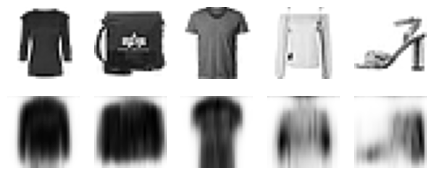

In [35]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [36]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=5,
                           validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3493 - rounded_accuracy: 0.8779 - val_loss: 0.3179 - val_rounded_accuracy: 0.9076
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3121 - rounded_accuracy: 0.9097 - val_loss: 0.3076 - val_rounded_accuracy: 0.9162
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3053 - rounded_accuracy: 0.9156 - val_loss: 0.3024 - val_rounded_accuracy: 0.9189
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3015 - rounded_accuracy: 0.9189 - val_loss: 0.2992 - val_rounded_accuracy: 0.9232
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2991 - rounded_accuracy: 0.9211 - val_loss: 0.2983 - val_rounded_accuracy: 0.9214


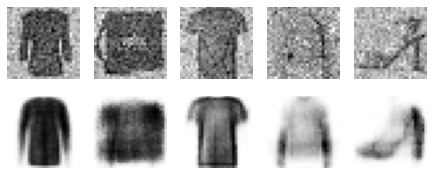

In [37]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [38]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=5,
                         validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3535 - rounded_accuracy: 0.8737 - val_loss: 0.3187 - val_rounded_accuracy: 0.9064
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3177 - rounded_accuracy: 0.9036 - val_loss: 0.3106 - val_rounded_accuracy: 0.9123
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3116 - rounded_accuracy: 0.9085 - val_loss: 0.3054 - val_rounded_accuracy: 0.9162
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3075 - rounded_accuracy: 0.9118 - val_loss: 0.3022 - val_rounded_accuracy: 0.9196
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3047 - rounded_accuracy: 0.9140 - val_loss: 0.2998 - val_rounded_accuracy: 0.9217


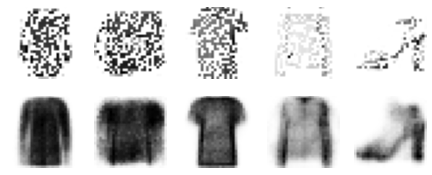

In [40]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [41]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=5,
                        validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4236 - rounded_accuracy: 0.8053 - val_loss: 0.3727 - val_rounded_accuracy: 0.8555
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3561 - rounded_accuracy: 0.8728 - val_loss: 0.3466 - val_rounded_accuracy: 0.8794
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3360 - rounded_accuracy: 0.8899 - val_loss: 0.3309 - val_rounded_accuracy: 0.8968
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3239 - rounded_accuracy: 0.8996 - val_loss: 0.3224 - val_rounded_accuracy: 0.9020
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3188 - rounded_accuracy: 0.9031 - val_loss: 0.3191 - val_rounded_accuracy: 0.9049


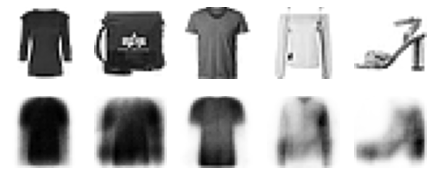

In [42]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [43]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [44]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

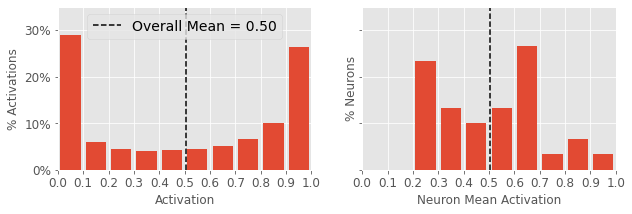

In [45]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [46]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=5,
                           validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4347 - rounded_accuracy: 0.8115 - val_loss: 0.3811 - val_rounded_accuracy: 0.8580
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3701 - rounded_accuracy: 0.8680 - val_loss: 0.3652 - val_rounded_accuracy: 0.8756
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3558 - rounded_accuracy: 0.8787 - val_loss: 0.3538 - val_rounded_accuracy: 0.8754
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3442 - rounded_accuracy: 0.8870 - val_loss: 0.3421 - val_rounded_accuracy: 0.8903
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3369 - rounded_accuracy: 0.8927 - val_loss: 0.3375 - val_rounded_accuracy: 0.8897


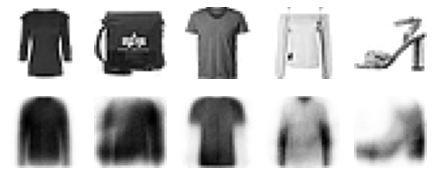

In [47]:
show_reconstructions(sparse_l1_ae)

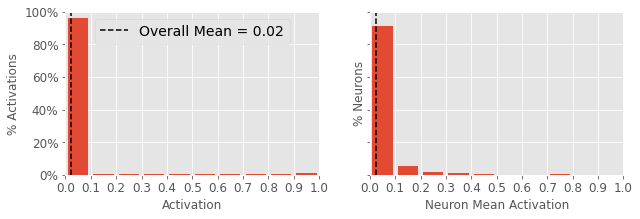

In [48]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

(0.0, 1.0, 0.0, 0.95)

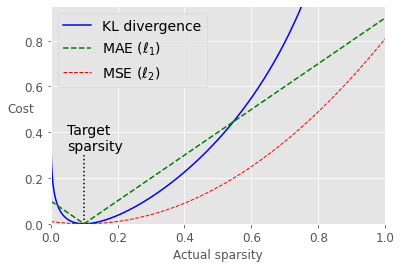

In [49]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [50]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [51]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=5,
                           validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4155 - rounded_accuracy: 0.8116 - val_loss: 0.3716 - val_rounded_accuracy: 0.8573
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3546 - rounded_accuracy: 0.8754 - val_loss: 0.3451 - val_rounded_accuracy: 0.8844
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3344 - rounded_accuracy: 0.8919 - val_loss: 0.3295 - val_rounded_accuracy: 0.8973
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3225 - rounded_accuracy: 0.9019 - val_loss: 0.3214 - val_rounded_accuracy: 0.9037
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3172 - rounded_accuracy: 0.9062 - val_loss: 0.3174 - val_rounded_accuracy: 0.9069


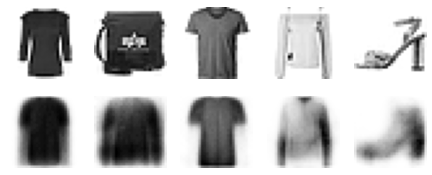

In [52]:
show_reconstructions(sparse_kl_ae)

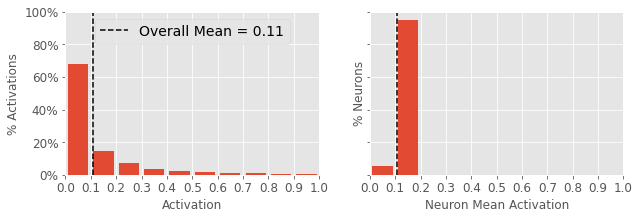

In [53]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

# Variational Autoencoder

In [54]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [55]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=5, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/5
430/430 [==============================] - 2s 6ms/step - loss: 0.3896 - rounded_accuracy: 0.8616 - val_loss: 0.3498 - val_rounded_accuracy: 0.8970
Epoch 2/5
430/430 [==============================] - 2s 5ms/step - loss: 0.3432 - rounded_accuracy: 0.8977 - val_loss: 0.3333 - val_rounded_accuracy: 0.9054
Epoch 3/5
430/430 [==============================] - 2s 5ms/step - loss: 0.3327 - rounded_accuracy: 0.9054 - val_loss: 0.3337 - val_rounded_accuracy: 0.9081
Epoch 4/5
430/430 [==============================] - 2s 5ms/step - loss: 0.3274 - rounded_accuracy: 0.9096 - val_loss: 0.3309 - val_rounded_accuracy: 0.9009
Epoch 5/5
430/430 [==============================] - 2s 5ms/step - loss: 0.3243 - rounded_accuracy: 0.9122 - val_loss: 0.3245 - val_rounded_accuracy: 0.9127


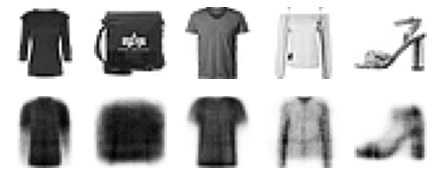

In [56]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [57]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

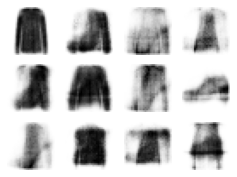

In [59]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Now let's perform semantic interpolation between these images:

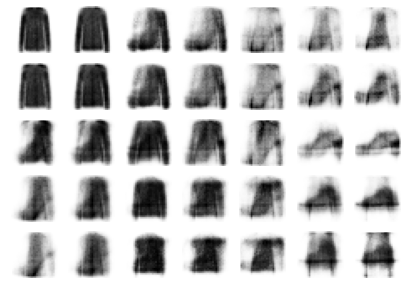

In [61]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

# Generative Adversarial Networks

In [62]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [63]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [64]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [69]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


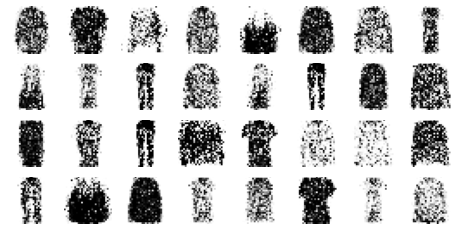

In [67]:
train_gan(gan, dataset, batch_size, codings_size)

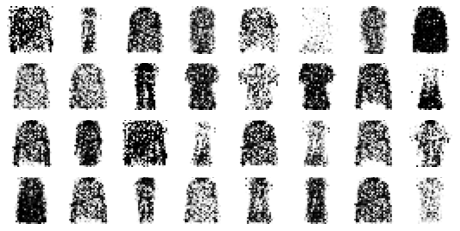

In [68]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Epoch 1/1


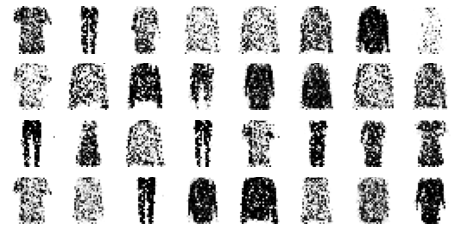

In [70]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [71]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [72]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [73]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [74]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/1


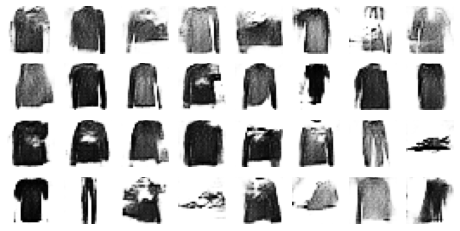

In [75]:
train_gan(gan, dataset, batch_size, codings_size)